In [9]:
pip install graphviz

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# classifier 생성
dt_clf=DecisionTreeClassifier(random_state=156)

# 데이터 로딩, 학습/테스트 데이터 세트 분리
iris_data=load_iris()
X_train,X_test,y_train,y_test=train_test_split(iris_data.data,iris_data.target,test_size=0.2,random_state=11)

# 학습
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=156)

In [11]:
from sklearn.tree import export_graphviz
# tree.dot 파일을 생성
export_graphviz(dt_clf, out_file='tree.dot',class_names=iris_data.target_names, feature_names=iris_data.feature_names,impurity=True,filled=True)

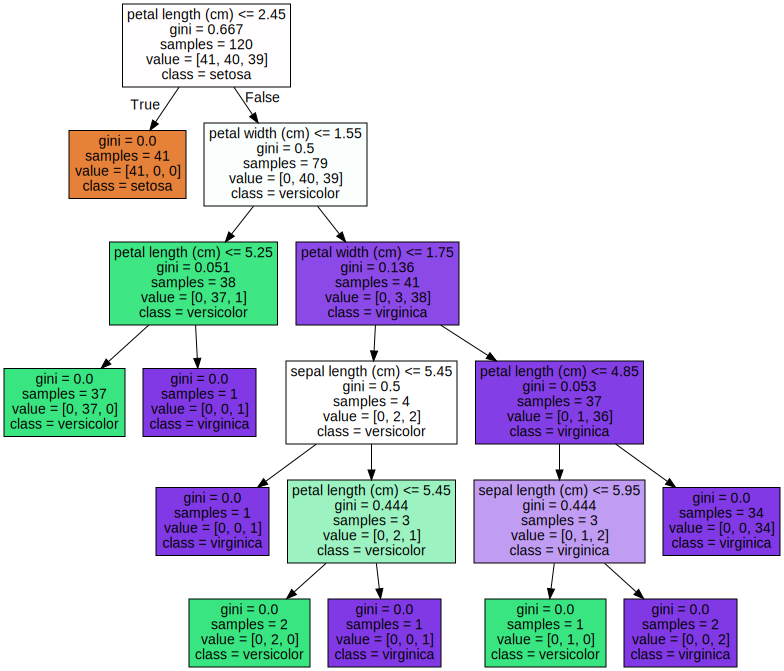

In [12]:
import graphviz

# 생성된 tree.dot 파일을 Graphiz가 읽어서 시각화
with open('tree.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

feature importances:
[0.02500521 0.         0.55490281 0.42009198]
sepal length (cm):0.025
sepal width (cm):0.000
petal length (cm):0.555
petal width (cm):0.420


<Axes: >

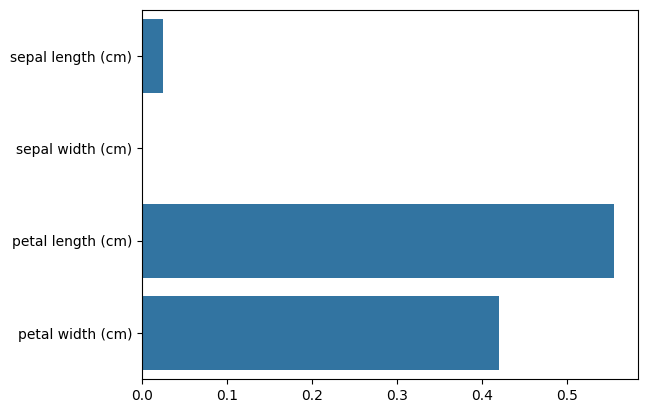

In [13]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출
print('feature importances:\n{0}'.format(dt_clf.feature_importances_,3))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0}:{1:.3f}'.format(name,value))

sns.barplot(x=dt_clf.feature_importances_,y=iris_data.feature_names)

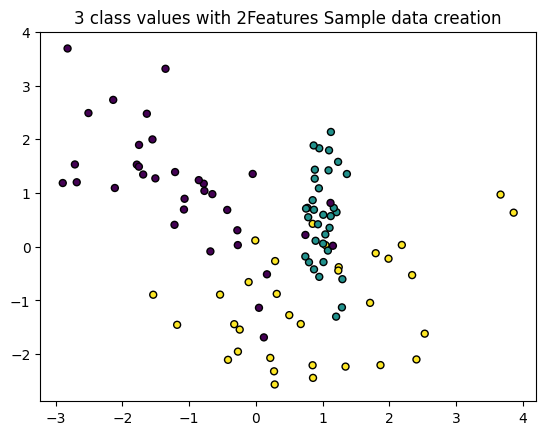

In [14]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 class values with 2Features Sample data creation')

# 피처 2개, 클래스 3가지 유형의 분류 샘플 데이터 생성
X_features, y_labels=make_classification(n_features=2,n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1,random_state=0)

# 각 피처가 x,y축으로 나열, 클래스 값은 색으로 구분
plt.scatter(X_features[:,0],X_features[:,1],marker='o',c=y_labels, s=25, edgecolor='k')

##**결정 트리 실습 - 사용자 행동 인식 데이터 세트**

In [2]:
from ast import increment_lineno
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# fearues.txt 파일을 dataframe으로 로드
from google.colab import drive
drive.mount('/content/gdrive')
directory_path = '/content/gdrive/My Drive/Colab Notebooks/Euron/데이터/human_activity/'
feature_name_df=pd.read_csv(directory_path +'features.txt',sep='\s+',header=None,names=['column_index','column_name'])

# 파일에 저장되어있던 index를 제거하고 피처명만 리스트 객체로 생성
feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:',feature_name[:10])

Mounted at /content/gdrive
전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
feature_dup_df=feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
# 중복된 피처명에 _1 또는 _2를 부여하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df=feature_dup_df.reset_index()  # 인덱스 초기화
    new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis=1)
    new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [5]:
def get_human_dataset():
    feature_name_df=pd.read_csv(directory_path +'features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    new_feature_name_df=get_new_feature_name_df(feature_name_df)
    feature_name=new_feature_name_df.iloc[:,1].values.tolist()

    X_train=pd.read_csv(directory_path +'/train/X_train.txt',sep='\s+',header=None,names=feature_name)
    X_test=pd.read_csv(directory_path +'/test/X_test.txt',sep='\s+',header=None,names=feature_name)

    y_train=pd.read_csv(directory_path +'/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test=pd.read_csv(directory_path +'/test/y_test.txt',sep='\s+',header=None,names=['action'])

    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_human_dataset()

In [30]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [31]:
# 레이블 값 분포 확인
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train,y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

# 하이퍼 파라미터 추출
print('decisiontreeclassifier 기본 하이퍼 파라미터:\n',dt_clf.get_params())

결정 트리 예측 정확도:0.8548
decisiontreeclassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


In [33]:
# Tree Depth가 예측 정확도에 주는 영향
from sklearn.model_selection import GridSearchCV

params={'max_depth':[6,8,10,12,16,20,24],'min_samples_split':[16]}

grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.8548794147162603
{'max_depth': 8, 'min_samples_split': 16}


In [34]:
cv_results_df=pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [39]:
max_depths=[6,8,10,12,16,20,24]
for depth in max_depths:
    dt_clf=DecisionTreeClassifier(max_depth=depth,min_samples_split=16,random_state=156)
    dt_clf.fit(X_train,y_train)
    pred=dt_clf.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    print('max_depth={0}, 정확도:{1:.4f}'.format(depth,accuracy))

max_depth=6, 정확도:0.8551
max_depth=8, 정확도:0.8717
max_depth=10, 정확도:0.8599
max_depth=12, 정확도:0.8571
max_depth=16, 정확도:0.8599
max_depth=20, 정확도:0.8565
max_depth=24, 정확도:0.8565


In [41]:
params={'max_depth':[8,12,16,20],'min_samples_split':[16,24]}
grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치:0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [42]:
best_df_clf=grid_cv.best_estimator_
pred1=best_df_clf.predict(X_test)
accuracy1=accuracy_score(y_test,pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy1))

결정 트리 예측 정확도:0.8717


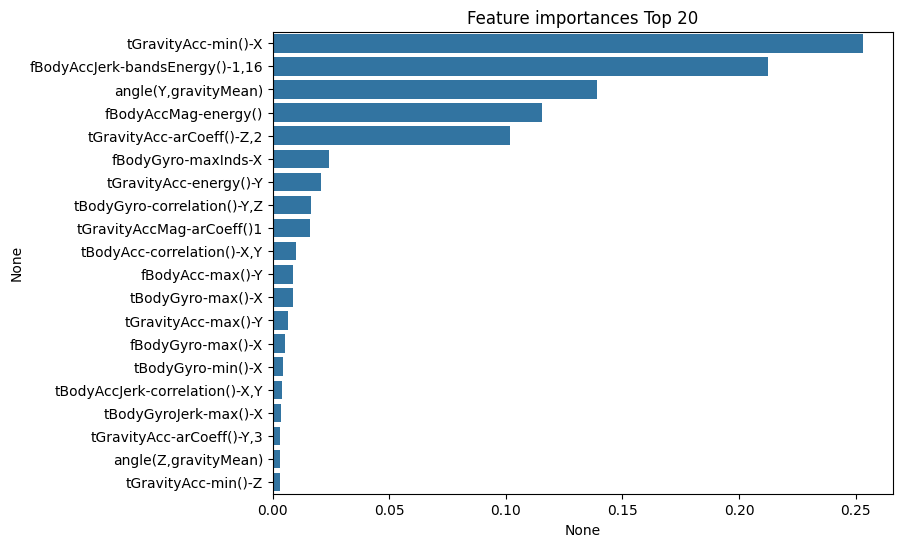

In [43]:
import seaborn as sns

ftr_importances_values=best_df_clf.feature_importances_
# 시리즈로 변환
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
# 시리즈를 중요도 순으로 정렬
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

#**앙상블 학습**

In [44]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [45]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


#**랜덤 포레스트**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test=get_human_dataset()

rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9223


In [8]:
from sklearn.model_selection import GridSearchCV

params={'max_depth':[8,16,24],'min_samples_leaf':[1,6,12],'min_samples_split':[2,8,16]}

rt_clf=RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(rt_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 예측 정확도:0.9157


In [9]:
# 추출한 최적 하이퍼 파라미터로 학습시키기
rf_clf1=RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train,y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도:0.9253


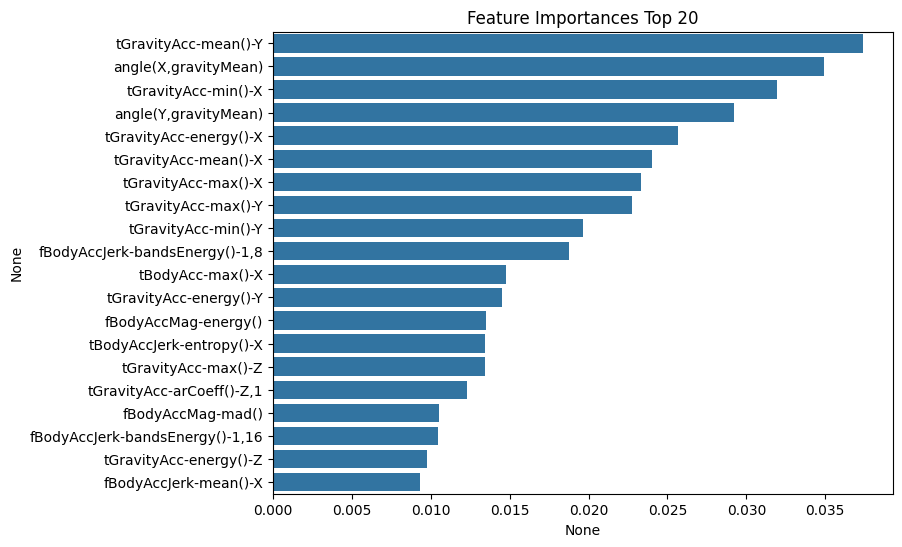

In [11]:
# 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()